In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import math
import time
from sklearn.linear_model import LinearRegression

In [2]:
path = "C:/Users/user/Desktop/HASADNA/קובץ_הרשויות_המקומיות_בישראל_2017.xlsx"
city_info = pd.read_excel(io=path,sheet_name="physical_data")
city_info.shape

(255, 284)

Some cities have no size info (indicated as "..")

In [3]:
city_clean = city_info.iloc[np.where((city_info.size_km2!=".."))[0],:]
city_clean.shape

(232, 284)

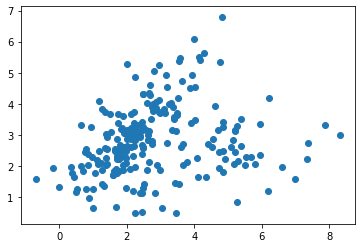

In [4]:
size_log = np.log(np.array(pd.array(city_clean.size_km2,dtype=float)))
pop_log = np.log(np.array(pd.array(city_clean.population_X100,dtype=float)))
plt.scatter(size_log.T,pop_log.T)

In [5]:
path_inv = "C:/Users/user/Desktop/HASADNA/involved_markers_hebrew.csv"
involved = pd.read_csv(path_inv)
print("number of documented accidents",involved.shape[0])
#involved.drop_duplicates(subset = 'accident_id',keep = 'first', inplace = True)
#print("number of documented accidents after filtering",involved.shape[0])

C:\Users\user\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (43,68) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


number of documented accidents 1678965


In [6]:
count_acc = involved.groupby('accident_yishuv_name')['accident_yishuv_name'].value_counts()
print(count_acc.__len__())

1233


In [7]:
table2plot = np.array([[],[],[]])
for yishuv in city_info.authority_name:
    if yishuv in count_acc.index:
        ind4city = np.where(city_info.authority_name == yishuv)[0][0]
        table2plot = np.append(table2plot,tuple([yishuv,count_acc[count_acc.index.get_loc(yishuv)][0],city_info["population_density"][ind4city]]))
table2plot = table2plot.reshape((len(table2plot)//3,3)).T
table2plot = table2plot[:,np.where(table2plot[2,]!="..")]

[[0.30519849]]
[5.38966383]
Rsquared =  0.24800898875546462


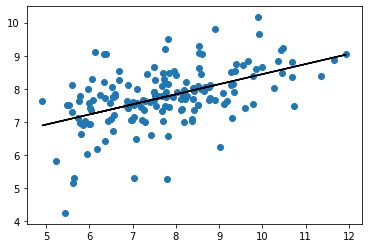

In [8]:
accidents_log = np.log(table2plot[1,].astype(float))
density_log = np.log(table2plot[2,].astype(float))
reg = LinearRegression()
reg.fit(accidents_log.T,density_log.T)
print(reg.coef_)
print(reg.intercept_)
print("Rsquared = ",reg.score(accidents_log.T,density_log.T))
pred = reg.predict(accidents_log.T)
plt.scatter(np.log(table2plot[1,].astype(float)),np.log(table2plot[2,].astype(float)))
plt.plot(accidents_log.T,pred,c='black')

### The correlation between the number of accidents and the population density is not so high, but there.

### I have to redo the population density since some are missing.
### I also normalize it so that Tel Aviv will get 1. called "normalized_pop_dens"

In [15]:
city_clean.population_density = city_clean.population_X100/city_clean.size_km2
pop_tlv = city_clean.population_density.loc[np.where(city_clean.authority_name=="תל אביב -יפו")[0]]
norm_dens = city_clean.population_density / float(pop_tlv)
#log_norm_pop_dens = np.log2(norm_dens.astype(float))
city_clean.norm_dens = norm_dens

C:\Users\user\Anaconda3\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


### OK. this is sort of normally distributed. the overhang probably rely from very non-densed areas, i.e., regional authorities.

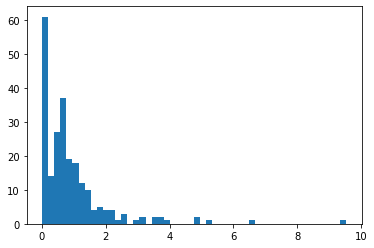

In [16]:
x=plt.hist(norm_dens,50)

I made a function "adjust_epsilon" in case I want to do the adjustment in another way.

In [90]:
eps = 50
def adjust_epsilon(eps=eps,norm_density=norm_dens):
    eps_new = float(eps)/norm_density
    return eps_new

## This function plot the DBscan with adjusted epsilon

In [76]:
def DBscan_city_eps(df=involved,city_clean=city_clean,city_name="תל אביב -יפו",eps=50,min_clust=6):
    ## Prepare the data by taking only accidents from the desired city since 2017, and clean duplicates
    city_inds = np.where((df.accident_year > 2015) & (df.involved_type == 3) & (df.accident_yishuv_name == city_name ) & df.location_accuracy == 1)[0]
    #print("In {0} there are {1} accidents since 2016".format(city_name,len(city_inds)))
    city_accidents = df.loc[city_inds,['accident_id','x','y','longitude','latitude']]
    print('number of accidents in {0} is: {1}'.format(city_name,city_accidents.shape[0]))
    city_accidents.drop_duplicates(subset = 'accident_id',keep = 'first', inplace = True)
    print('number of accidents in {0} after filtering for duplicates is: {1}'.format(city_name,city_accidents.shape[0]))
    city_norm_dens = city_clean.norm_dens[np.where(city_clean.authority_name==city_name)[0]].values[0]
    eps_new = adjust_epsilon(eps=eps,norm_density=city_norm_dens)
    print('The normalized city density in {0} is: {1}'.format(city_name,city_norm_dens))
    print('The adjusted epsilon in {0} is: {1}'.format(city_name,eps_new))
    ## make the DBscan
    db = DBSCAN(eps=eps_new, min_samples=min_clust).fit(city_accidents[['x','y']].values)
    ## Filter the accidents that are not clustered
    data2plot = city_accidents.iloc[(db.labels_ != -1) ,]
    ## Define colors for each cluster
    colors = db.labels_[db.labels_ != -1]
    ## plot!!!
    plt.scatter(data2plot.x,data2plot.y,c=colors,s=1,cmap='tab20')
    plt.title(label="City {0}\neps = {1}\nMinimal cluster size is {2}".format(city_name,eps,min_clust))

number of accidents in תל אביב -יפו is: 5108
number of accidents in תל אביב -יפו after filtering for duplicates is: 4524
The normalized city density in תל אביב -יפו is: 1.0
The adjusted epsilon in תל אביב -יפו is: 70.0


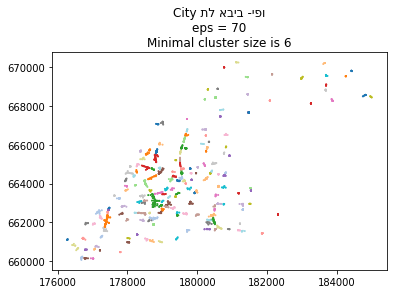

In [102]:
DBscan_city_eps(involved,city_clean,city_name="תל אביב -יפו",eps=70,min_clust=6)

number of accidents in אשקלון is: 1498
number of accidents in אשקלון after filtering for duplicates is: 1173
The normalized city density in אשקלון is: 1.2614463731838712
The adjusted epsilon in אשקלון is: 55.491855609621425


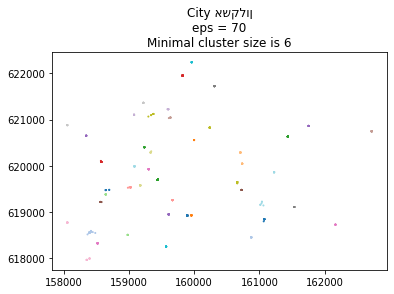

In [103]:
DBscan_city_eps(involved,city_clean,city_name="אשקלון",eps=70,min_clust=6)

number of accidents in חיפה is: 3124
number of accidents in חיפה after filtering for duplicates is: 2419
The normalized city density in חיפה is: 0.6041840487005965
The adjusted epsilon in חיפה is: 115.85873567921438


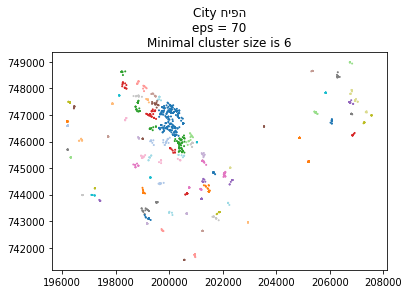

In [104]:
DBscan_city_eps(involved,city_clean,city_name="חיפה",eps=70,min_clust=6)